In [0]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [0]:
cd drive/My Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


#importing libraries

In [0]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import math
import os

import warnings
import networkx as nx
import pdb
import pickle

from google.colab import files
import random
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds, eigs
from tqdm import tqdm
from pandas import HDFStore,DataFrame
from pandas import read_hdf

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,roc_curve, auc

#Get dataset from kaggle API

In [0]:
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaraamin","key":"ffbfacd1e6355879ae48291b6bd80471"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/



In [0]:
#https://www.kaggle.com/c/FacebookRecruiting/data

In [0]:
!kaggle competitions download -c FacebookRecruiting



 92% 43.0M/46.7M [00:00<00:00, 46.5MB/s]
100% 46.7M/46.7M [00:00<00:00, 78.3MB/s]
 58% 27.0M/46.7M [00:00<00:01, 19.7MB/s]
100% 46.7M/46.7M [00:00<00:00, 79.6MB/s]
  0% 0.00/619k [00:00<?, ?B/s]
100% 619k/619k [00:00<00:00, 38.7MB/s]
 71% 33.0M/46.7M [00:00<00:00, 38.8MB/s]
100% 46.7M/46.7M [00:00<00:00, 86.6MB/s]
 62% 5.00M/8.01M [00:00<00:00, 34.5MB/s]
100% 8.01M/8.01M [00:00<00:00, 39.1MB/s]
 69% 22.0M/32.1M [00:00<00:00, 27.6MB/s]
100% 32.1M/32.1M [00:01<00:00, 33.1MB/s]
 51% 5.00M/9.78M [00:00<00:00, 29.6MB/s]
100% 9.78M/9.78M [00:00<00:00, 38.8MB/s]


#Data Visualization

In [0]:
#unzip the csv files
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [0]:
#reading graph and delete the headers
traincsv = pd.read_csv('train.csv')
print(traincsv[traincsv.isna().any(1)])
print(traincsv.info())
print("Number of diplicate entries: ",sum(traincsv.duplicated()))
traincsv.to_csv('train_woheader.csv',header=False,index=False)
print("saved the graph into file")
    

Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB
None
Number of diplicate entries:  0
saved the graph into file
Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB
None
Number of diplicate entries:  0
saved the graph into file


In [0]:
traincsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [0]:
#move to the directory of the data
cd Kaggle

/content/drive/My Drive/Kaggle


In [0]:
#get info of the network
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


In [0]:
# Number of unique persons

len(g.nodes())

1862220

#Data preprocessing

##Generate Bad links from graph which are not in graph and whose shortest path is greater than 2.


In [0]:

r = csv.reader(open('train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1
    
        
missing_edges = set([])
while (len(missing_edges)<9437519):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(g,source=a,target=b) > 2: 

                missing_edges.add((a,b))
            else:
                continue  
        except:  
                missing_edges.add((a,b))              
    else:
        continue
pickle.dump(missing_edges,open('missing_edges_final.p','wb'))

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

9437519

#Loading Data

In [0]:
df_pos = pd.read_csv(r'train_woheader.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

# Split Dataset into train and test

In [0]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
#save the splitted data into csv file
X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)

In [0]:
#visualize the shape of the dataset
print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])
    
print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

Number of nodes in the graph with edges 9437518
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550014 = 7550014
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [0]:
#read the csv files
X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])


In [0]:
#create new data of the positive and negative ones for y
y_train = np.concatenate((y_train_pos,y_train_neg))
y_test = np.concatenate((y_test_pos,y_test_neg)) 


In [0]:
#create new data of the positive and negative ones for X
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
X_test = X_test_pos.append(X_test_neg,ignore_index=True) 

In [0]:
#save data into csv files and retrieve it
X_train.to_csv('train_after_eda.csv',header=False,index=False)
X_test.to_csv('test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [0]:
#visualize the shape of the new data
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(15100029, 2) (15100029,) (3775008, 2) (3775008,)


# Feature Extraction

##Read data

In [0]:
#read data after eda
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780924
Number of edges: 7550014
Average in degree:   4.2394
Average out degree:   4.2394


##Jaccard Distance

In [0]:
#for followees
def jaccard_for_followees(a,b):
  try:
      print(len(set(train_graph.successors(a))),len(set(train_graph.successors(b))))
      if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
          return 0
      sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/(len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
  except:
      print("hi")
      return 0
  print(sim)
  return sim


#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

##Cosine Similarity

In [0]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0
#for followers

def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

##Page Rank

In [0]:
import pickle
if not os.path.isfile(r'page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open(r'page_rank.p','wb'))
else:
    pr = pickle.load(open(r'page_rank.p','rb'))
    
mean_pr = float(sum(pr.values())) / len(pr)

##Shortest Path

In [0]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

##Connected Components

In [0]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

##Adamic/Adar Index

In [0]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

##Follows back

In [0]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

##Kartz centrality

In [0]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz,open(r'katz.p','wb'))


##Hits Algorithm

In [0]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
pickle.dump(hits,open(r'hits.p','wb'))

##SVD features

In [0]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [0]:
from scipy.sparse.linalg import svds, eigs

#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()
U, s, V = svds(Adj, k = 6)

##weight features

In [0]:
from tqdm import tqdm
import numpy as np

Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780924/1780924 [00:12<00:00, 141134.30it/s]


#Data Combination of Features

In [0]:
n_train =  15100028
s = 100000
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(5)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,273084,1484794,1
1,258962,79184,1
2,132222,365522,1
3,1618992,1791582,1
4,1691811,566126,1


In [0]:
n_test = 3775006
s = 50000
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

df_final_test = pd.read_csv(os.path.join('test_after_eda.csv'), skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(5)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,301842,1
1,1849765,115543,1
2,279743,1828668,1
3,991374,89291,1
4,1822435,1173005,1


In [0]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0
#for followers

def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
#mapping jaccrd followers to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                        jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                        jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping cosine followers to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                        cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                        cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
df_final_train['num_followers_s'], df_final_train['num_followers_s'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)

df_final_test['num_followers_s'], df_final_test['num_followers_s'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

hdf = HDFStore(r'storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
df_final_train = read_hdf(r'storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf(r'storage_sample_stage1.h5', 'test_df',mode='r')

In [0]:
#mapping adar index on test
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

hdf = HDFStore(r'storage_sample_stage2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [0]:
mean_katz = float(sum(katz.values())) / len(katz)

#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
#================================================================================

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
#================================================================================

#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#================================================================================

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
#================================================================================

hdf = HDFStore(r'storage_sample_stage3.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [0]:
#mapping to pandas train
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

#mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


#some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

#some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [0]:
df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
#===================================================================================================

df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
#===================================================================================================

df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

#===================================================================================================

df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
#===================================================================================================

hdf = HDFStore(r'storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()


#Load Data

In [0]:
df_final_train = read_hdf(r'storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(r'storage_sample_stage4.h5', 'test_df',mode='r')

In [0]:
df_final_train.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followees', 'cosine_followees', 'num_followers_s',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4'],
      dtype='object')

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [0]:
df_final_train


,jaccard_followees,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4
0,0.055556,0.129099,3,15,4,1,1,3.321928,1,1,2,1.961569e-06,4.757810e-07,0.000778,0.000743,1.954121e-13,5.054059e-17,3.111973e-15,1.377672e-15,1.019605e-13,-6.572112e-13,-8.819311e-06,2.422223e-13,-1.916967e-13,3.602248e-12,-1.704648e-14,-2.239125e-14,-1.098618e-07,1.617435e-14,-6.249255e-15,9.316865e-16,-5.205799e-13,-7.954716e-13,-9.495677e-06,1.139988e-13,-5.959877e-13,5.795939e-14,3.130080e-15,-1.998653e-13,-1.506458e-07,2.711542e-15,-2.289222e-15,2.565864e-14,0.500000,0.250000,0.750000,0.125000,1.250000,1.000000
1,0.050000,0.095346,11,11,10,1,1,0.658539,1,1,2,5.441552e-07,7.176557e-07,0.000772,0.000775,4.963029e-13,1.489705e-14,1.550655e-13,5.814455e-15,-5.185591e-11,-3.286916e-10,-4.965936e-11,1.351735e-10,-9.704149e-10,9.148900e-12,-4.974918e-11,-1.689749e-10,-3.193846e-10,4.949460e-11,-8.696722e-11,2.746138e-13,-9.318856e-12,-1.089958e-09,-6.946733e-11,7.490989e-10,-1.579003e-10,2.888039e-12,-1.938287e-09,-4.107902e-11,-2.030262e-11,2.177042e-11,-1.870343e-09,1.082916e-13,0.288675,0.288675,0.577350,0.083333,0.866025,0.866025
2,0.093023,0.195180,9,35,12,3,4,3.471530,1,1,2,2.349335e-06,5.895782e-07,0.000861,0.000767,2.942000e-14,2.799871e-14,1.344663e-14,2.676856e-15,-2.313314e-13,-5.797346e-12,-1.164939e-11,3.953522e-11,-2.150889e-11,5.423310e-13,-1.008018e-13,-4.337112e-13,-2.191837e-12,1.356375e-11,-2.867358e-13,5.161311e-13,-2.162411e-12,-1.843070e-11,-2.248888e-11,6.256677e-12,-1.849230e-11,2.504386e-13,-5.208097e-13,-7.618956e-13,-1.440518e-12,2.965838e-12,-5.172387e-13,4.985548e-14,0.316228,0.166667,0.482894,0.052705,0.799122,0.649561
3,0.181818,0.316228,11,5,8,5,2,2.261159,1,1,2,1.099465e-06,1.297312e-06,0.000765,0.000773,2.925380e-17,3.081806e-17,1.207985e-17,1.319768e-15,-6.677416e-14,-8.145363e-13,-1.054457e-12,3.071162e-14,-1.831368e-13,5.391729e-16,-4.195164e-14,-8.573568e-13,-1.583891e-12,5.277859e-14,-7.950763e-14,5.679677e-16,-4.016296e-13,-5.828399e-13,-3.542340e-12,7.045128e-14,-3.062892e-13,2.249795e-16,-3.387364e-12,-1.637145e-12,-3.620600e-11,1.445912e-13,-1.351641e-11,2.458020e-14,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172
4,0.630435,0.773953,27,36,39,9,29,25.104405,1,1,2,4.465407e-07,1.060364e-06,0.000783,0.000836,8.225244e-16,8.941710e-16,6.484491e-16,6.439102e-16,-3.859672e-14,-1.185517e-12,-1.423704e-12,2.497297e-12,-1.679525e-11,1.516260e-14,-4.527603e-14,-1.494119e-12,-1.797779e-12,3.090089e-12,-1.589416e-11,1.648372e-14,-5.287844e-15,-5.851384e-13,-6.337271e-12,4.330002e-13,-1.346522e-12,1.207715e-14,-5.256908e-15,-5.758118e-13,-6.344621e-12,4.063996e-13,-1.202703e-12,1.199261e-14,0.188982,0.164399,0.353381,0.031068,0.542363,0.517780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0.000000,0.000000,1,2,0,0,0,0.000000,0,1,8,4.690823e-07,1.936241e-07,0.000743,0.000735,8.338283e-18,0.000000e+00,1.158506e-15,1.997597e-18,-6.119122e-15,-3.058851e-15,-9.933877e-15,3.347630e-13,-9.792662e-16,1.537123e-16,3.790241e-20,1.672693e-19,-1.254311e-19,4.162165e-20,1.962430e-19,1.365078e-20,-4.591946e-15,-2.153087e-13,-1.000770e-12,3.461279e-11,-1.097056e-13,2.157676e-14,-1.017395e-13,-2.164386e-15,-5.804958e-13,1.744703e-15,-1.691775e-15,3.720364e-17,0.707107,0.577350,1.284457,0.408248,1.991564,1.861807
99997,0.000000,0.000000,1,0,0,0,0,0.000000,0,1,-1,6.428291e-07,4.041889e-07,0.000735,0.000735,0.000000e+00

In [0]:
df_final_test


,jaccard_followers,cosine_followers,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4
0,0.000000,0.000000,13,5,17,0,0,0.000000,1,1,6,9.144861e-07,8.427080e-07,0.000762,0.000784,9.525373e-14,1.206031e-12,1.447964e-14,5.146692e-14,-1.001406e-11,-3.816288e-13,-1.307164e-10,3.883292e-12,-1.959645e-13,1.755918e-12,-1.026598e-10,-7.487487e-10,-1.570972e-09,6.040539e-11,-6.465148e-10,2.223210e-11,-1.457268e-12,-7.650448e-12,-1.054045e-10,1.182041e-12,-5.620231e-12,2.696781e-13,-9.553447e-06,-4.693521e-10,-3.976303e-08,2.801191e-11,-3.203336e-10,9.585529e-13,0.267261,0.408248,0.675510,0.109109,0.942771,1.083758
1,0.038462,0.021517,12,22,8,1,1,0.782011,0,1,2,1.021650e-06,6.323501e-07,0.000790,0.000780,2.254165e-16,2.480514e-16,6.114575e-16,6.421797e-16,-8.983449e-11,-5.342143e-12,-2.869970e-11,2.673146e-13,-9.028555e-14,4.155428e-15,-3.951541e-11,-2.685806e-11,-7.525757e-11,4.521901e-13,-6.049115e-13,4.572523e-15,-7.990214e-12,-6.153878e-12,-2.884670e-11,8.529340e-13,-3.093323e-12,1.138818e-14,-1.732120e-09,-3.320622e-11,-8.383195e-11,1.748130e-12,-3.782205e-12,1.196036e-14,0.277350,0.208514,0.485865,0.057831,0.763215,0.694379
2,0.285714,0.377964,2,4,3,2,1,1.660964,0,1,2,7.141569e-07,4.200983e-07,0.000758,0.000739,1.047842e-16,1.196666e-20,5.485766e-15,6.035006e-19,-3.490757e-15,-2.125473e-14,-5.876387e-14,7.681325e-14,-1.013709e-16,1.931546e-15,-2.459665e-18,-2.134205e-15,-3.075273e-15,3.135568e-17,-9.190376e-19,1.893997e-19,-1.073600e-13,-5.227496e-12,-1.113929e-09,3.603212e-13,-2.619874e-13,1.021704e-13,-1.072117e-16,-1.069934e-13,-2.105039e-13,1.286697e-15,-7.293527e-17,1.124025e-17,0.577350,0.447214,1.024564,0.258199,1.601914,1.471777
3,0.133333,0.090351,7,15,9,2,6,4.954546,1,1,2,6.080202e-07,5.483370e-07,0.000771,0.000759,1.247466e-15,4.622659e-16,2.725823e-16,1.398730e-16,-1.315430e-12,-1.154016e-12,-1.660994e-06,5.929858e-13,-2.018848e-11,2.299592e-14,-5.526464e-13,-6.798175e-13,-3.656466e-07,4.774336e-13,-8.433939e-14,8.521430e-15,-3.332769e-12,-2.605704e-13,-8.530031e-07,1.540127e-12,-3.328263e-13,5.076743e-15,-1.702131e-12,-4.700115e-12,-1.444404e-07,1.526351e-12,-3.572279e-13,2.605086e-15,0.353553,0.250000,0.603553,0.088388,0.957107,0.853553
4,0.054054,0.038222,37,42,9,2,2,1.085795,0,1,2,1.818672e-07,6.005881e-07,0.000740,0.000890,9.021029e-11,8.810126e-12,2.791074e-10,3.306621e-10,-1.774921e-14,-1.312739e-14,-3.506185e-13,1.695189e-09,-2.881047e-13,1.662946e-09,-3.027222e-15,-4.744942e-15,-2.345524e-14,3.834524e-11,-4.859438e-14,1.624068e-10,-5.162105e-16,-4.170597e-16,-1.526708e-14,6.091141e-11,-6.397991e-15,5.198275e-09,-7.512200e-15,-9.971044e-15,-2.103872e-13,7.362945e-10,-2.892712e-13,6.158462e-09,0.162221,0.152499,0.314720,0.024739,0.476941,0.467219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0.000000,0.000000,1,1,4,0,0,0.000000,0,1,-1,1.655488e-07,6.428291e-07,0.000731,0.000735,4.202736e-18,4.935879e-13,0.000000e+00,0.000000e+00,-6.379764e-18,-7.213638e-16,-4.343563e-15,6.527794e-16,-5.300004e-17,7.749172e-17,-3.033072e-11,-4.734836e-12,-5.227749e-10,6.086490e-13,-3.225870e-12,9.098852e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.284012e-22,-6.634530e-22,6.382013e-22,-4.220529e-22,-1.175908e-21,2.874428e-23,0.707107,0.707107,1.414214,0.500000,2.121320,2.121320
49998,0.000000,0.000000,7,0,5,0,0,0.000000,0,1,-1,1.720295e-06,3.032799e-07,0.000842,0.000761,0.000000e+00,3.

#Modelling

##build confusion matrix

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##Use Random Forest Classifier

###set paramters

In [0]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              





###Fit the model on the dataset

In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9478495783386234
Test f1 score 0.9196344549237753


###plot confusion matrix


Train confusion_matrix


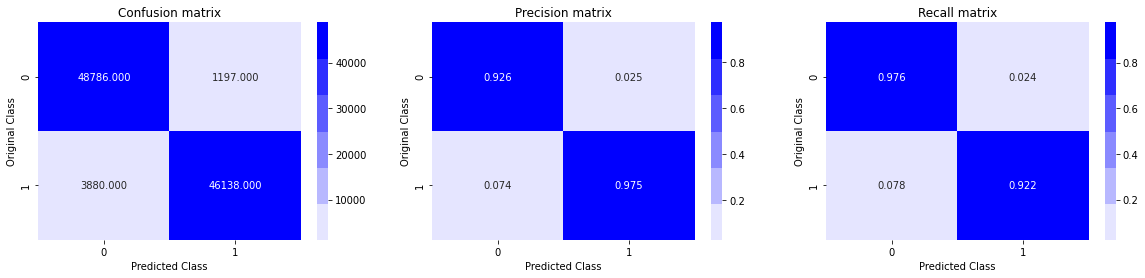

Test confusion_matrix


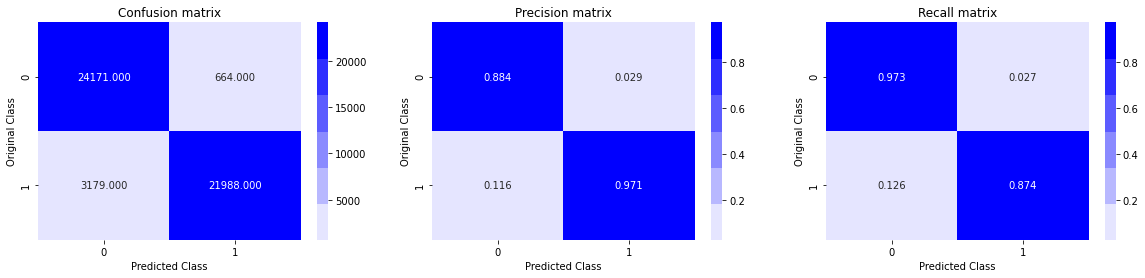

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)

print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

###plot roc_auc curve


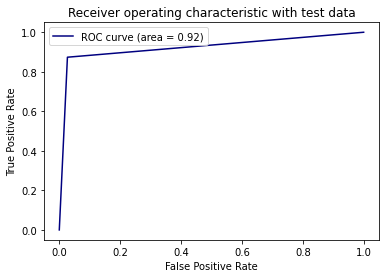

In [0]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()